<Axes: title={'center': 'Bike stands vs. time'}, xlabel='date'>

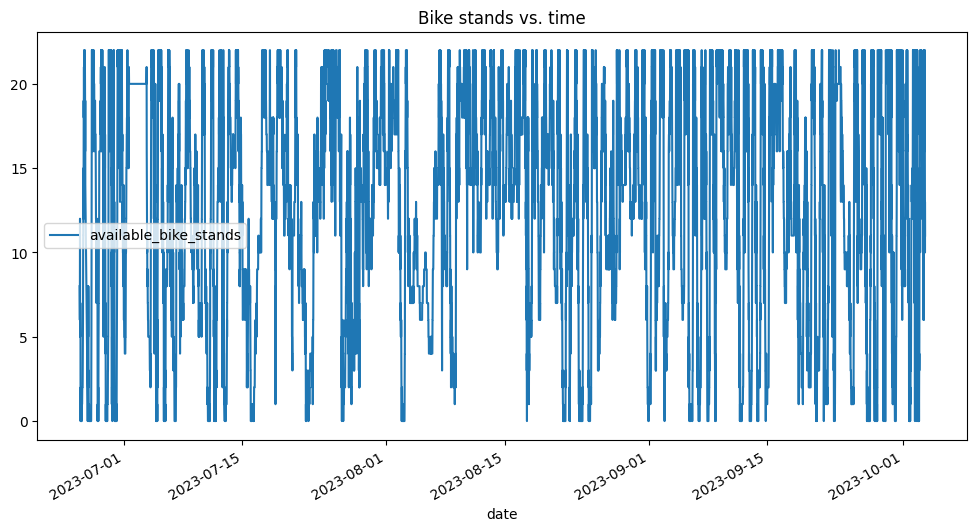

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from joblib import dump

df = pd.read_csv("/kaggle/input/mbajk-dataset/mbajk_dataset.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

df.plot(x='date', y='available_bike_stands', figsize=(12, 6), title='Bike stands vs. time')

In [137]:

time_series = df['available_bike_stands'].values.reshape(-1, 1)

scaler = MinMaxScaler()
time_series_normalized = scaler.fit_transform(time_series)

train_size = len(time_series) - 1302
train_data, test_data = time_series_normalized[0:train_size], time_series_normalized[train_size:]

def create_window_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 186
X_train, y_train = create_window_data(train_data, window_size)
X_test, y_test = create_window_data(test_data, window_size)

X_train = X_train.reshape(-1, 1, window_size)
X_test = X_test.reshape(-1, 1, window_size)


In [138]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model = Sequential([
    GRU(8, activation='relu', input_shape=(1, window_size), return_sequences=True),
    BatchNormalization(),
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer, loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
538/538 [==============================] - 4s 4ms/step - loss: 0.1812 - val_loss: 0.0758
Epoch 2/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0330 - val_loss: 0.0345
Epoch 3/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0218 - val_loss: 0.0253
Epoch 4/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0162 - val_loss: 0.0173
Epoch 5/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0212
Epoch 6/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0118 - val_loss: 0.0129
Epoch 7/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0101 - val_loss: 0.0124
Epoch 8/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0091 - val_loss: 0.0140
Epoch 9/30
538/538 [==============================] - 2s 3ms/step - loss: 0.0083 - val_loss: 0.0098
Epoch 10/30
538/538 [==============================] - 2s 4ms/step - loss: 0.0077 - val_loss: 0.0105

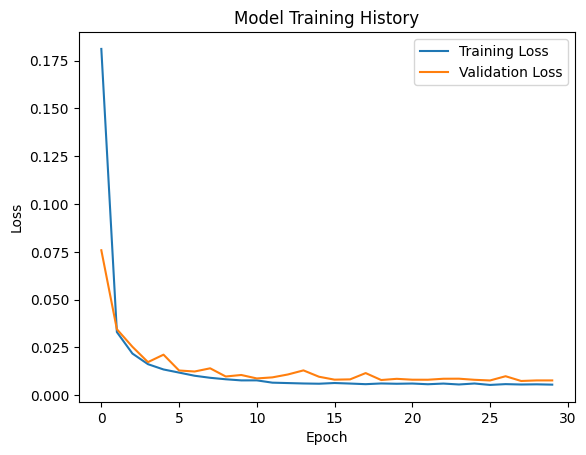

35/35 [==============================] - 0s 2ms/step
MAE: 1.3189530094891893
MSE: 3.7275247185577807
R^2: 0.926390282285324


In [139]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss = model.evaluate(X_test, y_test, verbose=0)

predictions = model.predict(X_test)

y_test_reshaped = y_test.reshape(-1)
predictions_reshaped = predictions.reshape(-1)

predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inverse, predictions_inverse)
mse = mean_squared_error(y_test_inverse, predictions_inverse)
r2 = r2_score(y_test_inverse, predictions_inverse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R^2: {r2}')


In [140]:
model = load_model('bike_stands_model.h5')

['scaler.joblib']

In [144]:
dump(scaler, 'bike_stands_scaler.joblib')

['bike_stands_scaler.joblib']

In [141]:
import os

if not os.path.exists('reports'):
    os.makedirs('reports')

with open("reports/test_metrics.txt", "w") as test_file:
    test_file.write(f"MAE: {mae}\n")
    test_file.write(f"MSE: {mse}\n")
    test_file.write(f"R^2: {r2}\n")


In [142]:
loss = model.evaluate(X_train, y_train, verbose=0)

predictions = model.predict(X_train)

y_train_reshaped = y_train.reshape(-1)
predictions_reshaped = predictions.reshape(-1)

predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))

train_mae = mean_absolute_error(y_train_inverse, predictions_inverse)
train_mse = mean_squared_error(y_train_inverse, predictions_inverse)
train_r2 = r2_score(y_train_inverse, predictions_inverse)

with open("reports/train_metrics.txt", "w") as train_file:
    train_file.write(f"MAE: {train_mae}\n")
    train_file.write(f"MSE: {train_mse}\n")
    train_file.write(f"R^2: {train_r2}\n")

538/538 [==============================] - 1s 1ms/step
